In [1]:
import numpy as np
from scipy.stats import truncnorm
import gymnasium as gym
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import matplotlib.pyplot as plt
import seaborn as sns

## 15-MPC模型预测控制
- **无模型（model-free）:** 基于值函数的方法 DQN，基于策略的方法 REINFORCE，两者结合的方法 Actor-Critic
- **基于模型（model-based）:** 用神经网络学习一个 **环境模型**,类似于Dyna-Q的思想生成模型数据加入策略训练中。

## MPC模型预测控制
模型预测控制（model predictive control，MPC）算法_并不构建一个显式的策略_，只根据环境模型来选择当前步要采取的动作

## 1.打靶法
类比于围棋的预期推演，生成候选动作序列的过程称为 **打靶(shooting)**，MPC主要有两个迭代:<br>
1. 历史数据学习环境模型
2. 真实环境+环境模型 来选择动作
$$
\underset{a_{k: k+H}}{\arg \max } \sum_{t=k}^{k+H} r\left(s_{t}, a_{t}\right) s.t. s_{t+1}=\hat{P}\left(s_{t}, a_{t}\right)
$$
其中$H$为推演长度，$argmax_{a_{k:k+H}}$则是从所有动作序列中选取累计奖励最大的序列<br>
根据当前状态，通过环境模型生成几条序列，选择累计奖励最大化的动作序列的第一个动作执行
### |交叉熵方法
**交叉熵方法（cross entropy method，CEM）**是一种进化策略方法，它的核心思想是**_维护一个带参数的分布_**，根据采样结果来更新参数，使得分布中能获得较高累积奖励的动作序列的概率比较高，具体做法如下：
- **for** 次数 $e=1 \rightarrow E$ **do**
    - 从分布 $P(\mathbf{A})$ 中选取 N 条动作序列 $\mathbf{A}_{1}, \ldots, \mathbf{A}_{N}$
    - 对于每条动作序列 $\mathbf{A}_{1}, \ldots, \mathbf{A}_{N} $，用环境模型评估累积奖励
    - 根据评估结果保留$ M $条最优的动作序列$ \mathbf{A}_{i_{1}}, \ldots, \mathbf{A}_{i_{M}}$
    - 用这些动作序列$ \mathbf{A}_{i_{1}}, \ldots, \mathbf{A}_{i_{M}} $去更新分布 $p(\mathbf{A})$
- **end for**
- 计算所有最优动作序列的第一个动作的均值，作为当前时刻采取的动作

#### 但是————不建议运行！！！
不建议运行，消耗时间很大

> 通过学习与实践，我们可以看出模型预测控制（MPC）方法有着其独特的优势，例如它不用构建和训练策略，可以更好地利用环境，可以进行更长步数的规划。但是 MPC 也有其局限性，例如模型在多步推演之后的准确性会大大降低，简单的控制策略对于复杂系统可能不够。MPC 还有一个更为严重的问题，即每次计算动作的复杂度太大，这使其在一些策略及时性要求较高的系统中应用就变得不太现实。

对于环境P, 其参数还是state和action, 每次传入一个s和a, 都会更新一次环境分布的mean和std

In [ ]:
class CEM:
    def __init__(self, n_sequence, elite_ratio, fake_env, upper_bound, lower_bound):
        self.n_sequence = n_sequence
        self.elite_ratio = elite_ratio #精英序列的比例
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.fake_env = fake_env

    def optimize(self, state, init_mean, init_var):
        '''输入状态，动作序列是截断正态分布生成的，保留回报比较高的动作序列，返回动作均值\\
            要注意的是，这里的回报是从`fake_env`得到的'''
        mean, var = init_mean, init_var
        # 截断x在-2到2的标准正态分布
        X = truncnorm(-2, 2, loc=np.zeros_like(mean), scale=np.ones_like(var))
        state = np.tile(state, (self.n_sequence, 1))  # 把state在当前维度复制n份

        for _ in range(5):
            # 约束和均值的差值
            lb_dist, ub_dist = mean - self.lower_bound, self.upper_bound - mean
            # 取约束范围和原本方差之间的最小值
            constrained_var = np.minimum(np.minimum(np.square(lb_dist / 2), np.square(ub_dist / 2)), var)
            # 生成动作序列, X.rvs()是抽取的样本, 乘以标准差加上均值还原动作, 返回一个动作序列
            action_sequences = [X.rvs() for _ in range(self.n_sequence)] * np.sqrt(constrained_var) + mean
            # 使用模拟环境fake_env评估每个动作序列的累积奖励，并保存在returns数组中
            returns = self.fake_env.propagate(state, action_sequences)[:, 0]
            # 选取累积奖励最高的若干条动作序列, ndarray[ndarray]可以按照索引重新排序, 取前面一定比例作为精英序列
            elites = action_sequences[np.argsort(returns)][-int(self.elite_ratio * self.n_sequence):]
            new_mean = np.mean(elites, axis=0)
            new_var = np.var(elites, axis=0)
            # 更新动作序列分布, 用于下一次迭代
            mean = 0.1 * mean + 0.9 * new_mean
            var = 0.1 * var + 0.9 * new_var
        # 返回的是动作序列的均值
        return mean

## 2.PETS算法
**带有轨迹采样的概率集成（probabilistic ensembles with trajectory sampling，PETS）** 是一种使用 MPC 的基于模型的强化学习算法。<br>
在 PETS 中，环境模型采用了集成学习的方法，即会构建多个环境模型，然后用这多个环境模型来进行预测，最后使用 CEM 进行模型预测控制。

我们通常认为一个系统中有两种不确定性，分别是：
- **偶然不确定性（aleatoric uncertainty）:** 由于系统中本身存在的随机性引起的
- **认知不确定性（epistemic uncertainty）:** 由“见”过的数据较少导致的自身认知的不足而引起的

因而PET构建环境模型会同时考虑到这两种不确定性，首先， **定义环境模型的输出为一个高斯分布** ，用来捕捉偶然不确定性：<br>
环境模型为，其参数为，那么基于当前状态动作对，下一个状态$s_t$的分布可以写为:
$$
\hat{P}\left(s_{t}, a_{t}\right)=\mathcal{N}\left(\mu_{\theta}\left(s_{t}, a_{t}\right), \Sigma_{\theta}\left(s_{t}, a_{t}\right)\right)
$$
其中，$\hat{p}$为环境模型，参数为$\theta$，则当前状态对为$(s_t,a_t)$

#### |损失函数：
采用神经网络构建$\mu_{\theta}$和$\Sigma_{\theta}$，这样损失函数为：
$$
\mathcal{L}(\theta)=\sum_{n=1}^{N}\left[\mu_{\theta}\left(s_{n}, a_{n}\right)-s_{n+1}\right]^{T} \Sigma_{\theta}^{-1}\left(s_{n}, a_{n}\right)\left[\mu_{\theta}\left(s_{n}, a_{n}\right)-s_{n+1}\right]+\log \operatorname{det} \Sigma_{\theta}\left(s_{n}, a_{n}\right)
$$

#### |"集成"捕捉不确定性
在此基础之上，我们选择用 **集成（ensemble）** 方法来捕捉认知不确定性，具体而言构建$B$个网络框架一样的神经网络：输入都是「状态动作对」，输出都是下一个状态的高斯分布的「均值向量」和「协方差矩阵」

#### |MPC算法--预测r&P
有了环境模型的集成后，MPC 算法会用其来预测奖励和下一个状态。具体来说，每一次预测会从个模型中挑选一个来进行预测，因此一条轨迹的采样会使用到多个环境模型，
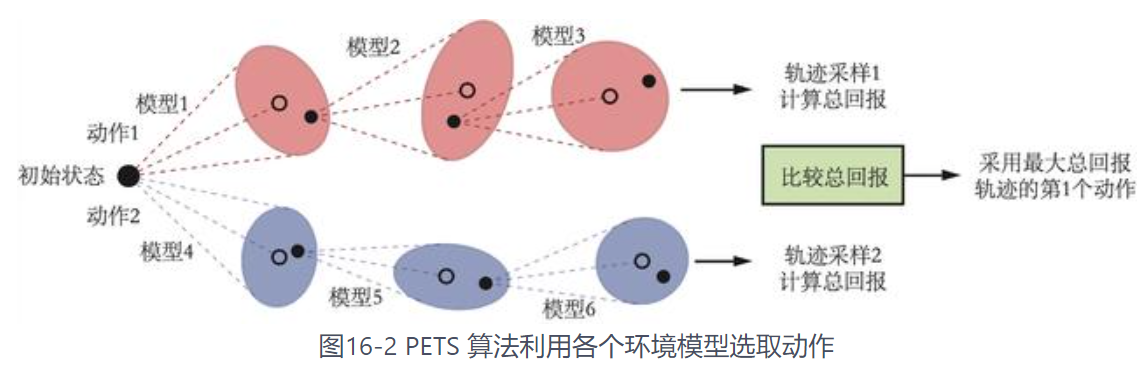

## 附录：
### 协方差
方差公式如下：
$$
\sigma_{x}^{2}=\frac{1}{n-1} \sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}
$$
协方差公式如下：
$$
\sigma(x, y)=\frac{1}{n-1} \sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)
$$
在公式中，符号$\bar{x}$, $\bar{y}$ 分别表示两个随机变量所对应的观测样本均值，据此，我们发现：方差 $\sigma_{x}^{2}$可视作随机变量 $x$ 关于其自身的协方差 $\sigma(x, x)$
$$
\sigma\left(x_{k}, x_{k}\right)=\frac{1}{n-1} \sum_{i=1}^{n}\left(x_{k i}-\bar{x}_{k}\right)^{2}, k=1,2, \ldots, d
$$
其中，$x_{ki}$是$x_k$的第$i$个观测样本，n为样本量<br>
对于这些随机变量，我们还可以根据协方差的定义，求出两两之间的协方差，即：
$$
\sigma\left(x_{m}, x_{k}\right)=\frac{1}{n-1} \sum_{i=1}^{n}\left(x_{m i}-\bar{x}_{m}\right)\left(x_{k i}-\bar{x}_{k}\right)
$$
#### 协方差矩阵
因此可以定义出协方差矩阵：
$$
\Sigma=\left[\begin{array}{ccc}\sigma\left(x_{1}, x_{1}\right) & \cdots & \sigma\left(x_{1}, x_{d}\right) \\ \vdots & \ddots & \vdots \\ \sigma\left(x_{d}, x_{1}\right) & \cdots & \sigma\left(x_{d}, x_{d}\right)\end{array}\right] \in \mathbb{R}^{d \times d}
$$

In [4]:
buffer_size = 100000
n_sequence = 50
elite_ratio = 0.2
plan_horizon = 25
num_episodes = 10
env_name = "Pendulum-v1"
env = gym.make(env_name)

obs, done, truncated, episode_return = env.reset()[0], False, False, 0

#env.observation_space.shape[0]
env.action_space.shape[0]

1

In [8]:
torch.Tensor(2,3,5)

tensor([[[1.0224e-03, 1.7796e-42, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]])

In [21]:
m1 = torch.Tensor([[[1],[2]],[[3],[4]]])
m2 = torch.Tensor([[[1,2]],[[3,4]]])

torch.bmm(m1,m2)

tensor([[[ 1.,  2.],
         [ 2.,  4.]],

        [[ 9., 12.],
         [12., 16.]]])

In [25]:
torch.zeros(5,4,10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0